# COPD phenotype clustering (k-means)

The goal of this project is to characterize the heterogeneity in the clinical presentation of COPD found in patients with this disease, by identifying subgroups of smokers using cluster analysis. We will try to replicate the results obtained in the thorax article "Cluster analysis in the COPDGene study identifies subtupes of smokers with distinct patterns of airway disease and emphysema" (Castaldi et al., https://thorax.bmj.com/content/69/5/416).

First, we have to import the python libraries that we are going to need for the project:

In [2]:
import pandas            as pd
import numpy             as np

from sklearn.cluster import KMeans 
from typing          import List

import PicSureClient
import PicSureBdcAdapter

## 1. Retrieving and saving the data from COPDGene:

The first step is to retrieve the dada we need from the COPDGene database. To do so, we will use the PIC-SURE API. Instructions on how to get a token and set up the necessary libraries can be found here: https://platform.sb.biodatacatalyst.nhlbi.nih.gov/u/biodatacatalyst/pic-sure-api/analysis/cruncher/pic-sure-examples/ . The function below can be found in the file *utils.py* in the *python_lib* folder in the provided url.

In [3]:
def get_multiIndex_variablesDict(variablesDict: pd.DataFrame) -> pd.DataFrame:

    def _varName_toMultiIndex(index_varDictionnary: pd.Index) -> pd.MultiIndex:
        long_names  = index_varDictionnary.tolist()
        splits      = [long_name.strip('\\').split('\\') for long_name in long_names]
        multi_index = pd.MultiIndex.from_tuples(splits)
        return multi_index

    def _get_simplified_varname(variablesDict_index: pd.MultiIndex) -> pd.DataFrame:
        tup_index            = variablesDict_index.tolist()
        last_valid_name_list = [[x for x in tup if str(x) != 'nan'][-1] for tup in tup_index]
        return last_valid_name_list
    
    def _get_number_modalities(categoryValues: pd.Series) -> pd.Series:
        for elem in categoryValues:
            if isinstance(elem, list):
                yield len(elem)
            else:
                yield np.NaN
                
    variablesDict        = variablesDict.rename_axis("name", axis=0).sort_index()
    multi_index          = _varName_toMultiIndex(variablesDict.index)
    last_valid_name_list = _get_simplified_varname(multi_index)
    variablesDict        = variablesDict.reset_index(drop=False)
    variablesDict.index  = multi_index.rename(["level_" + str(n) for n, _ in enumerate(multi_index.names)])
    variablesDict["nb_modalities"]   = list(_get_number_modalities(variablesDict["categoryValues"]))
    variablesDict["simplified_name"] = last_valid_name_list
    columns_order = ["simplified_name", "name", "observationCount", "categorical", "categoryValues", "nb_modalities", "min", "max", "HpdsDataType"]
    
    return variablesDict[columns_order]

Connecting to COPDGene through the PIC-SURE API:

In [4]:
PICSURE_network_URL = "https://picsure.biodatacatalyst.nhlbi.nih.gov/picsure"
resource_id         = "02e23f52-f354-4e8b-992c-d37c8b9ba140"
token_file          = "token.txt"

with open(token_file, "r") as f:
    my_token = f.read() 
    
client     = PicSureClient.Client() 
connection = client.connect(PICSURE_network_URL, my_token, True) 
adapter    = PicSureBdcAdapter.Adapter(connection) 
resource   = adapter.useResource(resource_id) 



+=========================================================================================+
|        [ WARNING ] you are specifying that you WANT to allow self-signed SSL            |
|        certificates to be acceptable for connections.  This may be useful for           |
|        working in a development environment or on systems that host public              |
|        data.  BEST SECURITY PRACTICES ARE THAT IF YOU ARE WORKING WITH SENSITIVE        |
|        DATA THEN ALL SSL CERTS BY THOSE EVIRONMENTS SHOULD NOT BE SELF-SIGNED.          |
+=========================================================================================+

+--------------------------------------+------------------------------------------------------+
|  Resource UUID                       |  Resource Name                                       |
+--------------------------------------+------------------------------------------------------+
| 02e23f52-f354-4e8b-992c-d37c8b9ba140 |                         

We generate a multi-index pandas dataframe with all the variables containing the term COPD:

In [5]:
plain_variablesDict = resource.dictionary().find('COPDGene').DataFrame() 
variablesDict       = get_multiIndex_variablesDict(plain_variablesDict) 
variablesDict

simplified_name  \
level_0                                            level_1                                            level_2                                                                                 
Genetic Epidemiology of COPD (COPDGene) Funded ... Subject ID and image files associated with part... De-identified subject ID                                     De-identified subject ID   
                                                                                                      Folder name of subject image                             Folder name of subject image   
                                                   Subject ID, consent group, subject source, sour... Affection status                                                     Affection status   
                                                                                                      Consent group as determined by DAC                 Consent group as determined by DAC   
                                                                                                      De-identified subject ID                                     De-identified subject ID   
...                                                                                                                                                                                     ...   
NHLBI TOPMed: Genetic Epidemiology of COPD (COP... TOPMed phase                                       NaN                                                                      TOPMed phase   
                                                   TOPMed project                                     NaN                                                                    TOPMed project   
                                                   Tumor status                                       NaN                                                                      Tumor status   
_studies                                           Genetic Epidemiology of COPD (COPDGene) Funded ... NaN                                 Genetic Epidemiology of COPD (COPDGene) Funded...   
                                                   NHLBI TOPMed: Genetic Epidemiology of COPD (COP... NaN                                 NHLBI TOPMed: Genetic Epidemiology of COPD (CO...   

                                                                                                                                                                                       name  \
level_0                                            level_1                                            level_2                                                                                 
Genetic Epidemiology of COPD (COPDGene) Funded ... Subject ID and image files associated with part... De-identified subject ID            \Genetic Epidemiology of COPD (COPDGene) Funde...   
                                                                                                      Folder name of subject image        \Genetic Epidemiology of COPD (COPDGene) Funde...   
                                                   Subject ID, consent group, subject source, sour... Affection status                    \Genetic Epidemiology of COPD (COPDGene) Funde...   
                                                                                                      Consent group as determined by DAC  \Genetic Epidemiology of COPD (COPDGene) Funde...   
                                                                                                      De-identified subject ID            \Genetic Epidemiology of COPD (COPDGene) Funde...   
...                                                                                                                                                                                     ...   
NHLBI TOPMed: Genetic Epidemiology of COPD (COP... TOPMed phase                                       NaN                                 \NHLBI TOPMed: Genetic

Next, we want to retrieve only the data that we need for our clustering problem. To do so, we first have to find the name under which they are saved in our variables dictionary. We can easily do so by searching for a match of a key word in the multi-index dictionary, creating a mask and applying it to our dataframe, so only the entries containing the key word will be shown. In the example below we are doing a search for any variables that cotain "Age" in the variable description at level 2. It shoudl be noticed that this search method is case sensitive, and so we should be mindful of lower and upper case letters.

In [10]:
mask = [type(i) == str and "Age"  in i for i in variablesDict.index.get_level_values(2)] 
age_variables = variablesDict.loc[mask,:] 
age_variables

simplified_name  \
level_0                                            level_1                                            level_2                                                                                                 
Genetic Epidemiology of COPD (COPDGene) Funded ... Subject ID, died center, age at enrolment, race... Age at enrollment                                                                   Age at enrollment   
                                                                                                      Age first attack of wheezing: don't know                     Age first attack of wheezing: don't know   
                                                                                                      Age wheezing started: don't know                                     Age wheezing started: don't know   
                                                                                                      Age when completely stopped smoking cigars [yea...  Age when completely stopped smoking cigars [ye...   
                                                                                                      Age when completely stopped smoking pipe [years...  Age when completely stopped smoking pipe [year...   
                                                                                                      Age when started to smoke cigars regularly [yea...  Age when started to smoke cigars regularly [ye...   
                                                                                                      Age when started to smoke pipe regularly [years...  Age when started to smoke pipe regularly [year...   

                                                                                                                                                                                                       name  \
level_0                                            level_1                                            level_2                                                                                                 
Genetic Epidemiology of COPD (COPDGene) Funded ... Subject ID, died center, age at enrolment, race... Age at enrollment                                   \Genetic Epidemiology of COPD (COPDGene) Funde...   
                                                                                                      Age first attack of wheezing: don't know            \Genetic Epidemiology of COPD (COPDGene) Funde...   
                                                                                                      Age wheezing started: don't know                    \Genetic Epidemiology of COPD (COPDGene) Funde...   
                                                                                                      Age when completely stopped smoking cigars [yea...  \Genetic Epidemiology of COPD (COPDGene) Funde...   
                                                                                                      Age when completely stopped smoking pipe [years...  \Genetic Epidemiology of COPD (COPDGene) Funde...   
                                                                                                      Age when started to smoke cigars regularly [yea...  \Genetic Epidemiology of COPD (COPDGene) Funde...   
                                                                                                      Age when started to smoke pipe regularly [years...  \Genetic Epidemiology of COPD (COPDGene) Funde...   

                                                                                                                                                          observationCount  \
level_0                                            level_1                                            level_2                                                                
Genetic Epidemiology of COPD (COPDGene) Funded ... Subject ID, died center, age at enrolment, race... Age at enr

We can display the result of our search to fine tune the key words needed, so that our search only yields the data we want. For example, in the example above, the search for "Age" yielded several results. If we were looking for the variable of the age at which patients enrolled in the study we could change our key word to "Age at enrollment" as that is the name under which it can be found in the dataframe. 

Once we have the variable we are interested in, we can retrieve the actual variable name, which we can then use to generate a query and retrieve the associated data.

In [15]:
# Retrieving the variable name for "Age of enrollment":
mask_1            = [type(i) == str and "Age at enrollment"  in i for i in variablesDict.index.get_level_values(2)] 
age_variables     = variablesDict.loc[mask_1,:] 
mask_2            = variablesDict["simplified_name"] == age_variables.index.get_level_values(2)[0] 
age_variable_name = variablesDict.loc[mask_2, "name"] 
print(age_variable_name) 

# Retrieving the associated data:
my_query = resource.query() # create the query
my_query.select().add(age_variable_name) # add the variable name to the query
query_result = my_query.getResultsDataFrame(low_memory=False) # retrieve the query results
query_result.dropna() # .dropna() removes the rows that contain empty values

level_0                                                                                                        level_1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

,Patient ID,"\Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute ( phs000179 )\Subject ID, died center, age at enrolment, race, ethnic, gender, body weight, body height, BMI, systolic and diastolic blood pressure, measurement of several parameters during 6 minutes work, CT slicer, CT scanner, heart rate, oxygen saturation and therapy, medical history of back pain, cancer, cardio vascular diseases, diabetes, digestive system diseases, eye diseases, general health, musculoskeletal diseases, painful joint type, respiratory tract disease, smoking, and walking limbs, medication history of treatment with beta-agonist, theophylline, inhaled corticosteroid, Oral corticosteroids, ipratropium bromide, and tiotroprium bromide, respiratory disease, St. George's Respiratory Questionnaire, SF-36 Health Survey, spirometry, and VIDA of participants with or without chronic obstructive pulmonary disease and involved in the 'Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute' project.\Age at enrollment\",\_Parent Study Accession with Subject ID\,\_Topmed Study Accession with Subject ID\,\_consents\
11412,35416,65.5,phs000179.v6_COPDGene_A00282,phs000951.v4_COPDGene_A00282,phs000179.c2
11413,35417,50.3,phs000179.v6_COPDGene_A00444,phs000951.v4_COPDGene_A00444,phs000179.c1
11415,35419,52.2,phs000179.v6_COPDGene_A01052,phs000951.v4_COPDGene_A01052,phs000179.c1
11416,35420,62.8,phs000179.v6_COPDGene_A01133,phs000951.v4_COPDGene_A01133,phs000179.c1
11417,35421,57.5,phs000179.v6_COPDGene_A01220,phs000951.v4_COPDGene_A01220,phs000179.c1
...,...,...,...,...,...
22030,46047,57.2,phs000179.v6_COPDGene_G07820,phs000951.v4_COPDGene_G07820,phs000179.c1
22040,46057,49.5,phs000179.v6_COPDGene_L18564,phs000951.v4_COPDGene_L18564,phs000179.c1
22054,46071,56.2,phs000179.v6_COPDGene_P75375,phs000951.v4_COPDGene_P75375,phs000179.c1
22067,46084,73.6,phs000179.v6_COPDGene_S98516,phs000951.v4_COPDGene_S98516,phs000179.c1


Using the variables in Castaldi's paper, we generated a list of the terms we need to retrieve the necessary variables for our clustering problem, and go through the process of retrieving the variable name and adding it to a query to retrieve the specified data.

In [45]:
var_names_find = ["Age at enrollment", "Race", "Gender", "FEV1 % pred", "BMI", "Pack", "Percent emphysema",
                  "Wall area percent: seg", "Upper Lobe/Lower", "gas trapping total", "Resting", "FEV1/FVC post"]  

my_query = resource.query() 

for var in var_names_find:
    mask_1      = [type(i) == str and var  in i for i in variablesDict.index.get_level_values(2)] 
    mask_1_vars = variablesDict.loc[mask_1,:] 
    mask_2      = variablesDict["simplified_name"] == mask_1_vars.index.get_level_values(2)[0] 
    mask_2_vars = variablesDict.loc[mask_2, "name"] 
    
    my_query.select().add(mask_2_vars) 

query_result = my_query.getResultsDataFrame(low_memory=False) 
query_result.dropna() 

,Patient ID,"\Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute ( phs000179 )\Subject ID, died center, age at enrolment, race, ethnic, gender, body weight, body height, BMI, systolic and diastolic blood pressure, measurement of several parameters during 6 minutes work, CT slicer, CT scanner, heart rate, oxygen saturation and therapy, medical history of back pain, cancer, cardio vascular diseases, diabetes, digestive system diseases, eye diseases, general health, musculoskeletal diseases, painful joint type, respiratory tract disease, smoking, and walking limbs, medication history of treatment with beta-agonist, theophylline, inhaled corticosteroid, Oral corticosteroids, ipratropium bromide, and tiotroprium bromide, respiratory disease, St. George's Respiratory Questionnaire, SF-36 Health Survey, spirometry, and VIDA of participants with or without chronic obstructive pulmonary disease and involved in the 'Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute' project.\Age at enrollment\","\Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute ( phs000179 )\Subject ID, died center, age at enrolment, race, ethnic, gender, body weight, body height, BMI, systolic and diastolic blood pressure, measurement of several parameters during 6 minutes work, CT slicer, CT scanner, heart rate, oxygen saturation and therapy, medical history of back pain, cancer, cardio vascular diseases, diabetes, digestive system diseases, eye diseases, general health, musculoskeletal diseases, painful joint type, respiratory tract disease, smoking, and walking limbs, medication history of treatment with beta-agonist, theophylline, inhaled corticosteroid, Oral corticosteroids, ipratropium bromide, and tiotroprium bromide, respiratory disease, St. George's Respiratory Questionnaire, SF-36 Health Survey, spirometry, and VIDA of participants with or without chronic obstructive pulmonary disease and involved in the 'Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute' project.\BMI\","\Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute ( phs000179 )\Subject ID, died center, age at enrolment, race, ethnic, gender, body weight, body height, BMI, systolic and diastolic blood pressure, measurement of several parameters during 6 minutes work, CT slicer, CT scanner, heart rate, oxygen saturation and therapy, medical history of back pain, cancer, cardio vascular diseases, diabetes, digestive system diseases, eye diseases, general health, musculoskeletal diseases, painful joint type, respiratory tract disease, smoking, and walking limbs, medication history of treatment with beta-agonist, theophylline, inhaled corticosteroid, Oral corticosteroids, ipratropium bromide, and tiotroprium bromide, respiratory disease, St. George's Respiratory Questionnaire, SF-36 Health Survey, spirometry, and VIDA of participants with or without chronic obstructive pulmonary disease and involved in the 'Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute' project.\FEV1 % pred post-bronch\","\Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute ( phs000179 )\Subject ID, died center, age at enrolment, race, ethnic, gender, body weight, body height, BMI, systolic and diastolic blood pressure, measurement of several parameters during 6 minutes work, CT slicer, CT scanner, heart rate, oxygen saturation and therapy, medical history of back pain, cancer, cardio vascular diseases, diabetes, digestive system diseases, eye diseases, general health, musculoskeletal diseases, painful joint type, respiratory tract disease, smoking, and walking limbs, medication history of treatment with beta-agonist, theophylline, inhaled corticosteroid, Oral corticosteroids, ipratropium bromide, and tiotroprium bromide, 

The variable names (column titles) are too long and not useful to work with, so we will change them to simpler and more efficient names. Also, we will not need the information on the last 3 columns (which contain information regarding the database itself), so we will remove them.

In [46]:
column_names = ['patient_ID', 'Age_Enroll', 'BMI', 'FEV1pp_utah', 'FEV1_FVC_utah', 'gender', 'ATS_PackYears', 
                'pctEmph', 'pctGasTrap', 'race', 'Resting_SaO2', 'pctEmph_UL_LL_ratio', 'WallAreaPct_seg'] 

query_result.drop(query_result.columns[[-3,-2,-1]], axis=1, inplace=True)  # remove the last 3 columns
query_result.columns = column_names # change the names of the columns left in our dataframe
query_result.dropna() 

,patient_ID,Age_Enroll,BMI,FEV1pp_utah,FEV1_FVC_utah,gender,ATS_PackYears,pctEmph,pctGasTrap,race,Resting_SaO2,pctEmph_UL_LL_ratio,WallAreaPct_seg
11412,35416,65.5,20.28,48.2,0.45,Female,16.8,13.2919,51.7130,Caucasian,95.0,1.427,62.1400
11413,35417,50.3,19.61,121.7,0.75,Male,22.7,4.9356,9.8893,African American,99.0,1.470,54.6783
11425,35429,45.6,20.54,38.4,0.42,Male,19.6,48.0393,69.8765,African American,95.0,2.128,61.5500
11429,35433,57.8,25.06,28.6,0.34,Male,32.0,25.2732,70.4505,Caucasian,89.0,0.354,63.8400
11434,35438,71.5,27.32,59.1,0.51,Male,94.5,7.8677,26.2439,Caucasian,91.0,4.091,61.2683
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22074,46091,72.7,32.34,37.2,0.34,Male,94.0,17.1484,49.6105,Caucasian,89.0,0.725,61.4150
22082,46099,65.1,20.52,39.5,0.42,Male,114.2,14.6262,70.0831,African American,89.0,1.110,64.2450
22083,46100,76.8,25.78,26.3,0.37,Female,60.8,20.0871,50.8687,Caucasian,88.0,0.957,65.6133
22096,46113,50.0,25.09,105.2,0.83,Male,22.5,3.8987,18.3584,African American,99.0,1.355,60.7800


Lastly, we will remove all empty rows (rows that only contain data for the patient ID, having all other fields empty), transform the categorical values into numeric values by assigning each category an integer number identifier, and add a new column with the random group identifier. The random group identifier will be used to later separate our data into separate training and testing sets in a random manner.

In [50]:
# Remove rows with no data other than the patient ID:
query_result.dropna(how='all', subset=column_names[1:], inplace=True)    

# Add a new column with the random group identifier (0 - 1):
group_codes = np.random.randint(0,2,len(query_result)) 
query_result.insert(loc=query_result.shape[-1], column='RandomGroupCode', value=group_codes)   

# Change the categorical values to numerical values:
query_result.loc[query_result['gender']=='Female', 'gender'] = 1
query_result.loc[query_result['gender']=='Male',   'gender'] = 2
query_result.loc[query_result['race']=='Caucasian',        'race'] = 1
query_result.loc[query_result['race']=='African American', 'race'] = 2

query_result

,patient_ID,Age_Enroll,BMI,FEV1pp_utah,FEV1_FVC_utah,gender,ATS_PackYears,pctEmph,pctGasTrap,race,Resting_SaO2,pctEmph_UL_LL_ratio,WallAreaPct_seg,RandomGroupCode
11412,35416,65.5,20.28,48.2,0.45,1,16.8,13.2919,51.7130,1,95.0,1.427,62.1400,1
11413,35417,50.3,19.61,121.7,0.75,2,22.7,4.9356,9.8893,2,99.0,1.470,54.6783,1
11415,35419,52.2,53.75,57.2,0.72,1,74.4,1.6590,9.1093,1,95.0,NaN,62.9417,0
11416,35420,62.8,22.66,84.9,0.69,1,26.0,0.5055,17.6785,1,97.0,NaN,59.2333,0
11417,35421,57.5,40.58,83.8,0.75,1,37.5,NaN,NaN,1,99.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22093,46110,52.8,33.57,94.0,0.95,1,26.1,NaN,NaN,2,96.0,NaN,NaN,1
22094,46111,61.9,24.87,96.0,0.66,1,29.2,NaN,NaN,2,99.0,NaN,NaN,1
22095,46112,51.7,22.78,71.4,0.82,1,16.5,0.2034,0.9951,1,98.0,NaN,59.7133,0
22096,46113,50.0,25.09,105.2,0.83,2,22.5,3.8987,18.3584,2,99.0,1.355,60.7800,0


We can then save our dataframe to a .csv to have a record of the data used for the proyect:

In [53]:
query_result.to_csv('BDSubmission_COPD_phenotyping.csv', index=False) 

## 2. Processing the data:

We can load the .csv we just created with one simple line of code:

In [54]:
# Load the .csv file into a dataframe:
df = pd.read_csv('BDSubmission_COPD_phenotyping.csv') 
df

,patient_ID,Age_Enroll,BMI,FEV1pp_utah,FEV1_FVC_utah,gender,ATS_PackYears,pctEmph,pctGasTrap,race,Resting_SaO2,pctEmph_UL_LL_ratio,WallAreaPct_seg,RandomGroupCode
0,35416,65.5,20.28,48.2,0.45,1,16.8,13.2919,51.7130,1,95.0,1.427,62.1400,1
1,35417,50.3,19.61,121.7,0.75,2,22.7,4.9356,9.8893,2,99.0,1.470,54.6783,1
2,35419,52.2,53.75,57.2,0.72,1,74.4,1.6590,9.1093,1,95.0,NaN,62.9417,0
3,35420,62.8,22.66,84.9,0.69,1,26.0,0.5055,17.6785,1,97.0,NaN,59.2333,0
4,35421,57.5,40.58,83.8,0.75,1,37.5,NaN,NaN,1,99.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10366,46110,52.8,33.57,94.0,0.95,1,26.1,NaN,NaN,2,96.0,NaN,NaN,1
10367,46111,61.9,24.87,96.0,0.66,1,29.2,NaN,NaN,2,99.0,NaN,NaN,1
10368,46112,51.7,22.78,71.4,0.82,1,16.5,0.2034,0.9951,1,98.0,NaN,59.7133,0
10369,46113,50.0,25.09,105.2,0.83,2,22.5,3.8987,18.3584,2,99.0,1.355,60.7800,0


Following the work of Castaldi (Castaldi et al., https://thorax.bmj.com/content/69/5/416), we will select the set of features that will be used for training and remove from those subjects that have missing values for either of the selected training features. <br><br>
We will also transform the data corresponding to "pctEmph" and "pctEmph_UL_LL_ratio" columns as specified in Castaldi's paper.

In [55]:
# Select the column names corresponding to the training features:
features_train = ['FEV1pp_utah', 'pctEmph', 'pctEmph_UL_LL_ratio', 'WallAreaPct_seg', 'RandomGroupCode'] 
# Create a subset of our original dataframe, which contains only the specified features, and remove 
# the rows that have missing values (NaN) for either of the features:
X = df[features_train].dropna() 

# Transform the values of the specified features (columns): 
X.loc[:, ('pctEmph')]             = np.log1p(X.loc[:, ('pctEmph')])  
X.loc[:, ('pctEmph_UL_LL_ratio')] = np.log(X.loc[:, ('pctEmph_UL_LL_ratio')])  

X

,FEV1pp_utah,pctEmph,pctEmph_UL_LL_ratio,WallAreaPct_seg,RandomGroupCode
0,48.2,2.659693,0.355574,62.1400,1
1,121.7,1.780968,0.385262,54.6783,1
12,38.4,3.892622,0.755183,61.5500,0
13,56.6,0.990841,-0.693147,62.3750,1
14,16.4,3.071373,-0.616186,68.4667,0
...,...,...,...,...,...
10347,37.2,2.898582,-0.321584,61.4150,0
10355,39.5,2.748949,0.104360,64.2450,0
10356,26.3,3.048661,-0.043952,65.6133,1
10369,105.2,1.588970,0.303801,60.7800,0


We then divide our data into two independent groups: a training set and a testing set. The training set will be used to train the K-means algorithm, while the testing set will be used to validate the results of the algorithm. In Castaldi's work the group codes go from 0 to 10, but we generated them to be either 0 or 1 as we only need to define two groups. Our training set will composed of all the subjects that have "RandomGroupCode" values equal to 0, while the test set will be composed of those subjects with "RandomGroupCode" equal to 1. We should have roughly the same amount of subjects in both sets.

In [56]:
X_train = X.loc[X['RandomGroupCode']==0] 
X_train = X_train[features_train] 
print('Training set:', len(X_train)) 

X_test = X.loc[X['RandomGroupCode']==1] 
X_test = X_test[features_train] 
print('Testing set: ', len(X_test)) 

X_train

Training set: 1860
Testing set:  1844


,FEV1pp_utah,pctEmph,pctEmph_UL_LL_ratio,WallAreaPct_seg,RandomGroupCode
12,38.4,3.892622,0.755183,61.5500,0
14,16.4,3.071373,-0.616186,68.4667,0
21,59.1,2.182415,1.408789,61.2683,0
29,40.5,3.236743,0.418710,62.2767,0
31,85.6,1.944724,-1.010601,62.5533,0
...,...,...,...,...,...
10333,43.3,2.125514,-0.640555,66.1220,0
10340,23.8,3.638778,0.516410,59.5733,0
10347,37.2,2.898582,-0.321584,61.4150,0
10355,39.5,2.748949,0.104360,64.2450,0


If we calculate the mean and the standard deviation of the training metrics, we can check that both training and testing sets have very similar distributions, which ensures the validity of the results that will be obtained over the testing set.

In [62]:
print('                     |     Train     |     Test     ') 
print('---------------------+---------------+--------------') 
for ff in features_train[:-1]:
    print('%20s | %5.2f (%5.2f) | %5.2f (%5.2f)' %(ff, np.mean(X_train[ff]), np.std(X_train[ff]),
                                                   np.mean(X_test[ff]), np.std(X_test[ff])))   

                     |     Train     |     Test     
---------------------+---------------+--------------
         FEV1pp_utah | 64.26 (28.15) | 65.42 (28.96)
             pctEmph |  2.38 ( 0.73) |  2.37 ( 0.74)
 pctEmph_UL_LL_ratio |  0.34 ( 0.75) |  0.33 ( 0.71)
     WallAreaPct_seg | 61.45 ( 3.24) | 61.21 ( 3.29)


## 3. K-means clustering:

In Castaldi's work, several clustering solutions are obtained and analized, to conlcude that the most stable solution is obtained with 4 clusters. We will train our k-means algorithm with 4 clusters to try and replicate the results displayed in Table 2 in their work. 

In [63]:
# Train the k-means algorithm over our training data, using 4 clusters:
kmeans   = KMeans(n_clusters=4) 
kmeans.fit(np.asarray(X_train)) 

# Make predictions on our testing set:
y_kmeans = kmeans.predict(X_test) 
print(y_kmeans) 

[1 2 1 ... 3 3 1]


The predicted values are the index of the cluster to which ech subject belongs, according to the k-means algorithm we just trained. We will store the indexes of the subjects belonging to each of the clusters for further analysis of the results. We can also use this information to calculate the number of subjects belonging to each cluster:

In [64]:
# Retrieve the list of points (from the testing set) that belong to each cluster:
c1 = X_test.index.values[y_kmeans==0] 
c2 = X_test.index.values[y_kmeans==1] 
c3 = X_test.index.values[y_kmeans==2] 
c4 = X_test.index.values[y_kmeans==3] 

print('Cluster 1: ', len(c1)) 
print('Cluster 2: ', len(c2)) 
print('Cluster 3: ', len(c3)) 
print('Cluster 4: ', len(c4)) 

Cluster 1:  494
Cluster 2:  465
Cluster 3:  426
Cluster 4:  459


## 4. Results:

We can compare the results we obtained to those displayed in Table 1 in the sumplementary material of Castaldi's work (which is also displayed in Table 2 of the main article). 

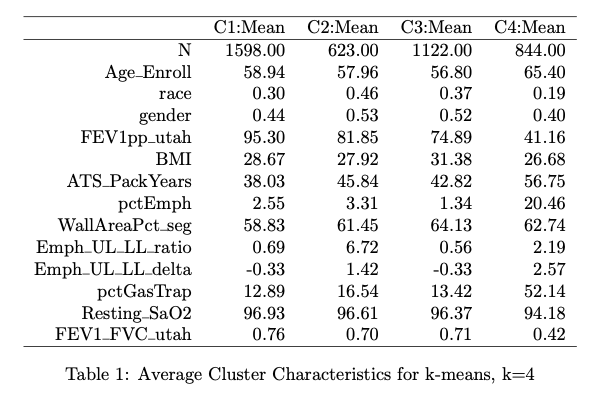

Our results are displayed following the sorting done in the paper, where the leftmost column (C3) corresponds to the cluster with the highest FEV1pp mean value, and the rightmost column (C4) is the one with the lowest FEV1pp mean value.

In [67]:
features_test = ['N', 'Age_Enroll', 'race', 'gender', 'FEV1pp_utah', 'BMI', 'ATS_PackYears', 'pctEmph', 
                 'WallAreaPct_seg', 'pctEmph_UL_LL_ratio', 'pctGasTrap', 'Resting_SaO2', 'FEV1_FVC_utah'] 

# Analyze the mean of the analysis features for each cluster:
c1_means = [len(c1)] 
c2_means = [len(c2)] 
c3_means = [len(c3)] 
c4_means = [len(c4)]  

for ff in features_test[1:]:
    c1_means.append(np.mean(analysis_df[ff].iloc[c1])) 
    c2_means.append(np.mean(analysis_df[ff].iloc[c2])) 
    c3_means.append(np.mean(analysis_df[ff].iloc[c3])) 
    c4_means.append(np.mean(analysis_df[ff].iloc[c4])) 

print('                           C3       C1       C2       C4') 
for ii in np.arange(len(features_test)):
    print('%20s   %6.2f   %6.2f   %6.2f   %6.2f' % (features_test[ii], c3_means[ii], c1_means[ii], 
                                                    c2_means[ii], c4_means[ii])) 


                           C3       C1       C2       C4
                   N   426.00   494.00   465.00   459.00
          Age_Enroll    60.50    62.74    65.35    64.80
                race     1.19     1.21     1.18     1.16
              gender     1.64     1.64     1.58     1.60
         FEV1pp_utah   103.87    78.97    52.31    28.45
                 BMI    27.94    28.52    27.45    25.62
       ATS_PackYears    39.96    48.35    53.23    57.89
             pctEmph     6.36     7.56    14.17    24.87
     WallAreaPct_seg    58.63    60.45    62.40    63.23
 pctEmph_UL_LL_ratio     1.73     2.06     1.87     1.84
          pctGasTrap    19.52    25.51    43.16    60.07
        Resting_SaO2    96.77    96.27    94.60    93.18
       FEV1_FVC_utah     0.75     0.66     0.50     0.34
